In [ ]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [1]:
import Models.Heat_Conduction.Heat_2D_FEM as Heat_2D_FEM
import numpy as np
factorial = np.math.factorial

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# custom module where PCE functions are written
import Surrogates.PolynomialChaosExpansion as PCE

# Gauß-Legendre Quadrature

In [2]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights

    return quad_points, quad_weights

In [3]:
def PlateQuadrature(plate_corners, quad_points_in_x, quad_points_in_y, plot = True):

    total_quad_points = quad_points_in_x*quad_points_in_y

    X_quad_points, X_quad_weights = GaussLegendreQuadrature(plate_corners[0], plate_corners[2], quad_points_in_x)
    Y_quad_points, Y_quad_weights = GaussLegendreQuadrature(plate_corners[1], plate_corners[3], quad_points_in_y)

    X_grid, Y_grid = np.meshgrid(X_quad_points, Y_quad_points)
    X_weight_grid, Y_weight_grid = np.meshgrid(X_quad_weights, Y_quad_weights)

    X_grid = np.reshape(X_grid, [-1,1])
    Y_grid = np.reshape(Y_grid, [-1,1])

    X_weight_grid = np.reshape(X_weight_grid, [-1, 1])
    Y_weight_grid = np.reshape(Y_weight_grid, [-1, 1])

    # [X_coord, Y_coord, X_weight*Y_weight]
    Quad_coord_weight_matrix = np.hstack((X_grid, Y_grid, X_weight_grid, Y_weight_grid))

    if plot == True:

        fig, ax = plt.subplots()

        plate_edges = [ [(0, 0), (0.5, 0)],       # lower edge
                        [(0, 0), (0, 0.25)],      # left edge
                        [(0, 0.25), (0.5, 0.25)], # upper edge 
                        [(0.5, 0), (0.5, 0.25)] ] # right edge 

        # numbering quadrature points 
        for i, txt in enumerate(np.arange(total_quad_points)):
            ax.annotate(txt+1, (X_grid[i] + 0.005, Y_grid[i]) )

        lc = mc.LineCollection(plate_edges, color = 'blue', linewidths=2)
        ax.plot(X_grid, Y_grid, '.', markersize=3, color = 'black')
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
        ax.set_title('2D Gauß-Legendre Quadrature')
        plt.show()

    return total_quad_points, Quad_coord_weight_matrix

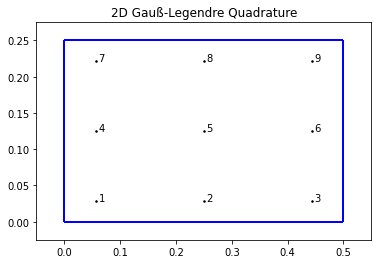

In [4]:
# X0, Y0, X1, Y1 
plate_corners = [0, 0, 0.5, 0.25] 

quad_points_in_x = 3
quad_points_in_y = 3 
 
total_quad_points, Quadrature_matrix = PlateQuadrature(plate_corners, quad_points_in_x, quad_points_in_y)

# Model Evaluations

In [5]:
# nEleX = number of elements in the X-direction
# nEleY = number of elements in the Y-direction
nEleX = 20
nEleY = nEleX/2

model = Heat_2D_FEM.Heat_2D_FEM_solver(nEleX, nEleY)

# lambda_x = Thermal Conductivity in the X-direction
# lambda_y = Thermal Conductivity in the Y-direction 

# Number of realizations
N = 50

a = [1, 3] 
b = [1, 3]  

lambda_x = np.random.uniform(a[0], a[1],(N,1))
lambda_y = np.random.uniform(b[0], b[1],(N,1))

SampleSpace = np.hstack((lambda_x, lambda_y))

# matrix to store solution corresponding 
# to each realization of random variable
# size: [N, number of quadrature points]
func_evaluations = np.zeros((N, total_quad_points))

for i in range(N):

    _, solution_u, solution_quad_points = model.solve(lambda_x[i], lambda_y[i], Quadrature_matrix[:,:2])

    func_evaluations[i,:] = solution_quad_points.flatten()

# Isoprobabilistic Transform

In [6]:
def isoprobabilistic_transform(any_X):

    a = [1, 3] 
    b = [1, 3]  

    temp = np.copy(any_X)

    temp[:,0] = ( temp[:,0] - ( a[1] + a[0] )/2 )/ ( ( a[1] - a[0] )/2 )
    temp[:,1] = ( temp[:,1] - ( b[1] + b[0] )/2 )/ ( ( b[1] - b[0] )/2 )

    return temp

In [11]:
class Domain_aware_PCE_surrogate(PCE.PCE_surrogate):

    # Inherit from class PCE_surrogate from PCE module

    def __init__(self, SampleSpace, func_evals, total_polynomial_degree, polynomial_classes_of_random_variables, quad_info, isoprob_transform):

        self.X = SampleSpace
        self.func_evals = func_evals
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables 
        self.N_p = len(self.pcrv)
        self.isoprob_transform = isoprob_transform
        self.total_quad_points = quad_info.shape[0]
        
        X_weight_vector = quad_info[:, 2]
        Y_weight_vector = quad_info[:, 3]

        self.quad_weights = X_weight_vector*Y_weight_vector

        # set classes of random variables
        for i in range(self.N_p):
            
            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre

        #total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))

        # compute all permutations of monomials which have total degree <= n
        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)


    def generalised_Sobol(self):

        first_order_picker, total_order_picker = self.coefficient_pickers()

        # store coefficients of polynomial surrogates
        # each column contains polynomial coefficients corresponding to each point(t_m)
        # size = [number_of_PCE_terms, number of quadrature points] '''
        store_beta = np.zeros((self.number_of_PCE_terms, self.total_quad_points))

        for i in range(self.total_quad_points):

            store_beta[:,i] = self.find_coefficients(self.X, self.func_evals[:,i])

        G_first_numerator = first_order_picker @ (store_beta**2) @ self.quad_weights
        G_tot_numerator = total_order_picker @ (store_beta**2) @ self.quad_weights

        G_denominator = (store_beta**2) @ self.quad_weights

        # leave out constant coefficient
        G_denominator = np.sum(G_denominator[1:])

        # first generalised Sobol index
        # size [N_p, 1]
        G_first = G_first_numerator/G_denominator

        # total generalised Sobol index
        # size [N_p, 1]
        G_tot = G_tot_numerator/G_denominator

        # convert [N_p,1] matrix to [N_p,]
        # easier to handle
        self.G_tot = G_tot.reshape(self.N_p)

        'Plots'
        fig, ax = plt.subplots(figsize=(8,5))

        'Histogram of general total Sobol indices at t=T'
        params = [r'$\lambda_x$=' + str(np.around(self.G_tot[0], 4)), 
                r'$\lambda_y$=' + str(np.around(self.G_tot[1], 4))]

        ax.bar(params, self.G_tot)
        ax.set_xlabel('Parameters')
        ax.set_ylabel('Total General Sobol indices')

        # plt.savefig('Domain_aware.jpeg', bbox_inches = "tight", dpi = 300)

        plt.show()

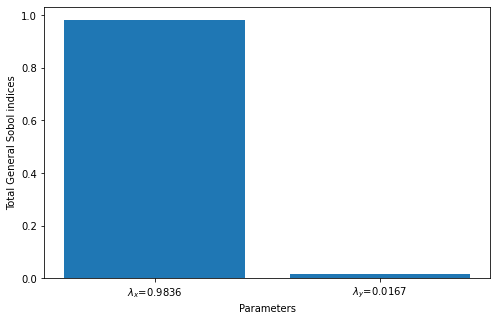

In [12]:
total_polynomial_degree = 2
polynomial_classes_of_random_variables = ['Legendre', 'Legendre']

Domain_aware_PCE = Domain_aware_PCE_surrogate(SampleSpace, func_evaluations, total_polynomial_degree, polynomial_classes_of_random_variables, Quadrature_matrix)

Domain_aware_PCE.generalised_Sobol()